In [7]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import astropy.units as u
from astroduet.duet_sensitivity import calc_exposure
import numpy as np
from matplotlib import pyplot as plt
from astroduet.bbmag import bb_abmag_fluence, bb_abmag
from astroduet.utils import get_neff

import astroduet.config as config
from astroduet.background import background_pixel_rate


from astropy.visualization import quantity_support
import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
duet = config.Telescope(config='largest_aperture')
duet.config_list

['baseline',
 'classic',
 'minimum_mass',
 'fine_plate',
 'equal_mass',
 'largest_aperture',
 'reduced_baseline']

{'sig': <Quantity [2.08, 4.26] arcsec>,
 'amp': [1, 0.1],
 'norm': [0.505053538858156, 0.21185072119504136]}

In [25]:
f = plt.figure(figsize=[16, 9])
for ind, tel_type in enumerate(duet.config_list):


    duet = config.Telescope(config=tel_type)
    print(tel_type, duet.psf_params)
#    psf = duet.psf_model()
#    print(tel_type, duet.compute_psf_norms(), psf.array.sum())

baseline {'sig': <Quantity [2.08, 4.26] arcsec>, 'amp': [1, 0.1], 'norm': [0.505053538858156, 0.21185072119504136]}
classic {'sig': [<Quantity 2. arcsec>], 'amp': [1.0], 'norm': [0.624335784627981]}
minimum_mass {'sig': [<Quantity 3.5351 arcsec>], 'amp': [1.0], 'norm': [0.9845499186721847]}
fine_plate {'sig': [<Quantity 1.4084 arcsec>], 'amp': [1], 'norm': [0.48927044820341287]}
equal_mass {'sig': [<Quantity 2.4144 arcsec>], 'amp': [1], 'norm': [0.9589514449942292]}
largest_aperture {'sig': [<Quantity 3.018 arcsec>], 'amp': [1.0], 'norm': [0.9967376175195871]}
reduced_baseline {'sig': <Quantity [2.08, 4.26] arcsec>, 'amp': [1, 0.1], 'norm': [0.505053538858156, 0.21185072119504136]}


<Figure size 1152x648 with 0 Axes>

classic
minimum_mass
fine_plate
equal_mass
largest_aperture
reduced_baseline


Text(0, 0.5, 'Fraction of Eclosed Energy')

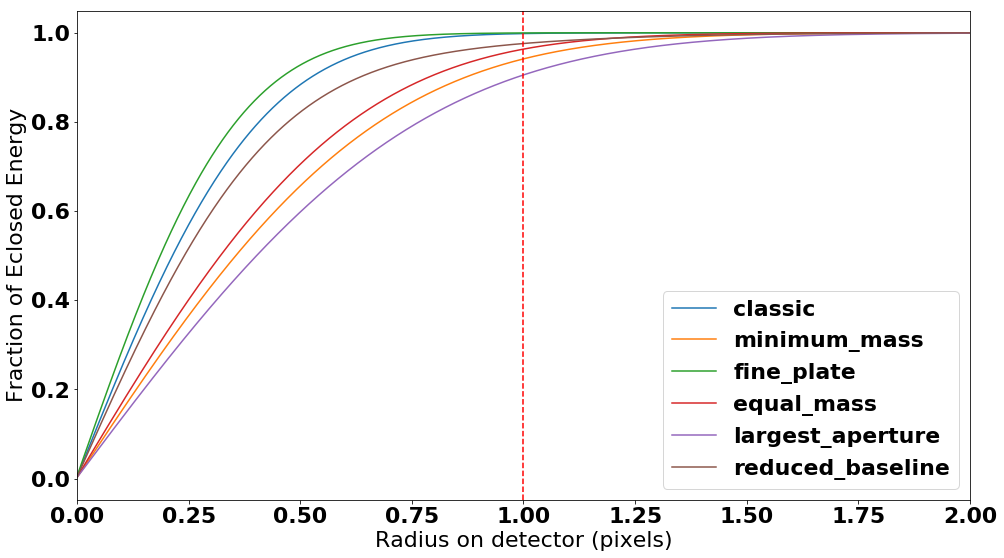

In [31]:
f = plt.figure(figsize=[16, 9])
for ind, tel_type in enumerate(duet.config_list):
    if ind == 0:
        continue
    print(tel_type)
    duet = config.Telescope(config=tel_type)

    pix, radpro = duet.calc_radial_profile()
    psf = duet.psf_model()
    rind = np.arange(0,len(radpro))*pix / duet.pixel
    eef = np.cumsum(radpro)
    plt.plot(rind, eef /eef.max(), label=duet.config)
    plt.xlim([0, 2])
plt.legend()
plt.axvline(x=1., linestyle = '--', color ='r')
plt.xlabel('Radius on detector (pixels)')
plt.ylabel('Fraction of Eclosed Energy')


In [34]:
# FOM: Time to 22 ABmag for this configuration for DUET1
# Old FOM for this 

siglimit=10
swiftmag = 21
dmag = 0.05
bbmag1 = 5*u.ABmag
bbmag_target = 22.0*u.ABmag

duet = config.Telescope(config='classic')
bandone = duet.bandpass1
bandtwo = duet.bandpass2
while bbmag1 < bbmag_target:
    swiftmag+=dmag
    bbmag1, bbmag2 = bb_abmag(swiftmag=swiftmag*u.ABmag, bbtemp=15e3*u.K, bandone = bandone, bandtwo=bandtwo)
print(f"""-----
        Swift AB mag {swiftmag}
        DUET1 AB mag {bbmag1}
        DUET2 AB mag {bbmag2}""")



for ind, tel_type in enumerate(duet.config_list):
    if ind == 0:
        continue

    print()
    duet = config.Telescope(config=tel_type)
    duet.read_noise=3
    

#    duet.config, duet.psf_fwhm, duet.neff)

    siglimit=10
    bandone = duet.bandpass1
    bandtwo = duet.bandpass2

#     # Low Zodi, 10-sigma case
    [bgd_band1, bgd_band2] = background_pixel_rate(duet, low_zodi=True)
    band1_fluence, foo = bb_abmag_fluence(duet = duet, swiftmag=swiftmag*u.ABmag, bbtemp=15e3*u.K)
    band1_rate = duet.fluence_to_rate(band1_fluence)
    req_exp = calc_exposure(siglimit, band1_rate, bgd_band1, duet.read_noise, duet.neff)
#    print('Low-Zodi {}-sig, {} seconds'.format(siglimit, req_exp.value))
    
    [bgd_band1, bgd_band2] = background_pixel_rate(duet, med_zodi=True)
    band1_fluence, foo = bb_abmag_fluence(duet = duet, swiftmag=swiftmag*u.ABmag, bbtemp=15e3*u.K)
    band1_rate = duet.fluence_to_rate(band1_fluence)
    req_exp = calc_exposure(siglimit, band1_rate, bgd_band1, duet.read_noise, duet.neff)
#     print('Med-Zodi {}-sig, {} seconds'.format(siglimit, req_exp.value))
#     print('Med-Zodi {}-sig, {} FoM min'.format(siglimit, 2*req_exp.value/60.))
#     print('Med-Zodi {}-sig, {} 300-s frames'.format(siglimit, 2*req_exp.value/300.))

    # High Zodi, 10-sigma case.
    [bgd_band1, bgd_band2] = background_pixel_rate(duet, high_zodi=True)
    band1_fluence, foo = bb_abmag_fluence(duet = duet, swiftmag=swiftmag*u.ABmag, bbtemp=15e3*u.K)
    band1_rate = duet.fluence_to_rate(band1_fluence)
    req_exp = calc_exposure(siglimit, band1_rate, bgd_band1, duet.read_noise, duet.neff)
#    print('High-Zodi {}-sig, {} seconds'.format(siglimit, req_exp.value))

    print(f"""-----
        Config: {duet.config}
        PSF: {duet.psf_fwhm}
        Pixel: {duet.pixel}
        Neff: {duet.neff}
        Frame Duration: {req_exp.value}
        FOM (minutes to survey error box): {2*req_exp.value/60.}
    """)
#    print('High-Zodi {}-sig, {} FoM min'.format(siglimit, 2*req_exp.value/60.))


#     # High Zodi, 5-sigma case
#     siglimit=10
#     [bgd_band1, bgd_band2] = background_pixel_rate(duet, high_zodi=True)
#     band1_fluence, foo = bb_abmag_fluence(duet = duet, swiftmag=swiftmag*u.ABmag, bbtemp=15e3*u.K)
#     band1_rate = duet.fluence_to_rate(band1_fluence)

#     req_exp = calc_exposure(siglimit, band1_rate, bgd_band1, duet.read_noise, duet.neff)
#     print('High-Zodi {}-sig, {} seconds'.format(siglimit, req_exp.value))
    



-----
        Swift AB mag 22.000000000000014
        DUET1 AB mag 22.000470091092396 mag(AB)
        DUET2 AB mag 21.58825736350795 mag(AB)

-----
        Config: classic
        PSF: 4.6 arcsec
        Pixel: 6.25 arcsec
        Neff: 3.915397310924053
        Frame Duration: 1011.1678631631258
        FOM (minutes to survey error box): 33.705595438770864
    

-----
        Config: minimum_mass
        PSF: 8.2 arcsec
        Pixel: 6.67 arcsec
        Neff: 5.816888480720367
        Frame Duration: 1478.7525906815235
        FOM (minutes to survey error box): 49.29175302271745
    

-----
        Config: fine_plate
        PSF: 3.2 arcsec
        Pixel: 5.03 arcsec
        Neff: 4.309068332163228
        Frame Duration: 870.5182440951069
        FOM (minutes to survey error box): 29.017274803170228
    

-----
        Config: equal_mass
        PSF: 5.4 arcsec
        Pixel: 5.03 arcsec
        Neff: 5.976635786074825
        Frame Duration: 680.3219264440609
        FOM (minutes t

In [47]:
# FOM: Time to 22 ABmag for this configuration for DUET1
# Old FOM for this 

siglimit=10
swiftmag = 21
dmag = 0.05
bbmag1 = 5*u.ABmag
bbmag_target = 22.0*u.ABmag

duet = config.Telescope(config='classic')
bandone = duet.bandpass1
bandtwo = duet.bandpass2
while bbmag1 < bbmag_target:
    swiftmag+=dmag
    bbmag1, bbmag2 = bb_abmag(swiftmag=swiftmag*u.ABmag, bbtemp=15e3*u.K, bandone = bandone, bandtwo=bandtwo)
print(f"""-----
        Swift AB mag {swiftmag}
        DUET1 AB mag {bbmag1}
        DUET2 AB mag {bbmag2}""")


psfs = np.arange(5, 20, 0.1)
foms = np.zeros_like(psfs)
tel_type = 'classic'
for ind, psf in enumerate(psfs):

    duet = config.Telescope(config=tel_type)
    duet.read_noise=3
    print(psf*u.arcsec)
    duet.psf_fwhm = psf*u.arcsec
    duet.neff = get_neff(duet.psf_fwhm, duet.pixel)
    
    print(duet.config, duet.psf_fwhm, duet.neff)

    siglimit=10
    bandone = duet.bandpass1
    bandtwo = duet.bandpass2

    # High Zodi, 10-sigma case.
    [bgd_band1, bgd_band2] = background_pixel_rate(duet, high_zodi=True)
    band1_fluence, foo = bb_abmag_fluence(duet = duet, swiftmag=swiftmag*u.ABmag, bbtemp=15e3*u.K)
    band1_rate = duet.fluence_to_rate(band1_fluence)
    req_exp = calc_exposure(siglimit, band1_rate, bgd_band1, duet.read_noise, duet.neff)
#    print('High-Zodi {}-sig, {} seconds'.format(siglimit, req_exp.value))

    foms[ind] = 2*req_exp.value/60.

#     print(f"""-----
#         Config: {duet.config}
#         PSF: {duet.psf_fwhm}
#         Pixel: {duet.pixel}
#         Neff: {duet.neff}
#         Frame Duration: {req_exp.value}
#         FOM (minutes to survey error box): {2*req_exp.value/60.}
#     """)
#    print('High-Zodi {}-sig, {} FoM min'.format(siglimit, ))
    

#     # High Zodi, 5-sigma case
#     siglimit=10
#     [bgd_band1, bgd_band2] = background_pixel_rate(duet, high_zodi=True)
#     band1_fluence, foo = bb_abmag_fluence(duet = duet, swiftmag=swiftmag*u.ABmag, bbtemp=15e3*u.K)
#     band1_rate = duet.fluence_to_rate(band1_fluence)

#     req_exp = calc_exposure(siglimit, band1_rate, bgd_band1, duet.read_noise, duet.neff)
#     print('High-Zodi {}-sig, {} seconds'.format(siglimit, req_exp.value))
    




-----
        Swift AB mag 22.000000000000014
        DUET1 AB mag 22.000470091092396 mag(AB)
        DUET2 AB mag 21.58825736350795 mag(AB)
5.0 arcsec
classic 5.0 arcsec 2.972404255319149
5.1 arcsec
classic 5.1 arcsec 3.010552340425532
5.199999999999999 arcsec
classic 5.199999999999999 arcsec 3.048700425531915
5.299999999999999 arcsec
classic 5.299999999999999 arcsec 3.0868485106382977
5.399999999999999 arcsec
classic 5.399999999999999 arcsec 3.1249965957446806
5.499999999999998 arcsec
classic 5.499999999999998 arcsec 3.163144680851063
5.599999999999998 arcsec
classic 5.599999999999998 arcsec 3.2012927659574464
5.6999999999999975 arcsec
classic 5.6999999999999975 arcsec 3.239440851063829
5.799999999999997 arcsec
classic 5.799999999999997 arcsec 3.2775889361702117
5.899999999999997 arcsec
classic 5.899999999999997 arcsec 3.3227702127659557
5.9999999999999964 arcsec
classic 5.9999999999999964 arcsec 3.389051063829785
6.099999999999996 arcsec
classic 6.099999999999996 arcsec 3.4553319148

15.599999999999962 arcsec
classic 15.599999999999962 arcsec 15.264313191489292
15.699999999999962 arcsec
classic 15.699999999999962 arcsec 15.443843404255249
15.799999999999962 arcsec
classic 15.799999999999962 arcsec 15.623373617021207
15.899999999999961 arcsec
classic 15.899999999999961 arcsec 15.802903829787166
15.999999999999961 arcsec
classic 15.999999999999961 arcsec 15.982434042553123
16.09999999999996 arcsec
classic 16.09999999999996 arcsec 16.161964255319077
16.19999999999996 arcsec
classic 16.19999999999996 arcsec 16.34899489361694
16.29999999999996 arcsec
classic 16.29999999999996 arcsec 16.545668936170138
16.39999999999996 arcsec
classic 16.39999999999996 arcsec 16.742342978723325
16.499999999999957 arcsec
classic 16.499999999999957 arcsec 16.93901702127651
16.59999999999996 arcsec
classic 16.59999999999996 arcsec 17.135691063829707
16.69999999999996 arcsec
classic 16.69999999999996 arcsec 17.3323651063829
16.799999999999958 arcsec
classic 16.799999999999958 arcsec 17.52903

(0, 60)

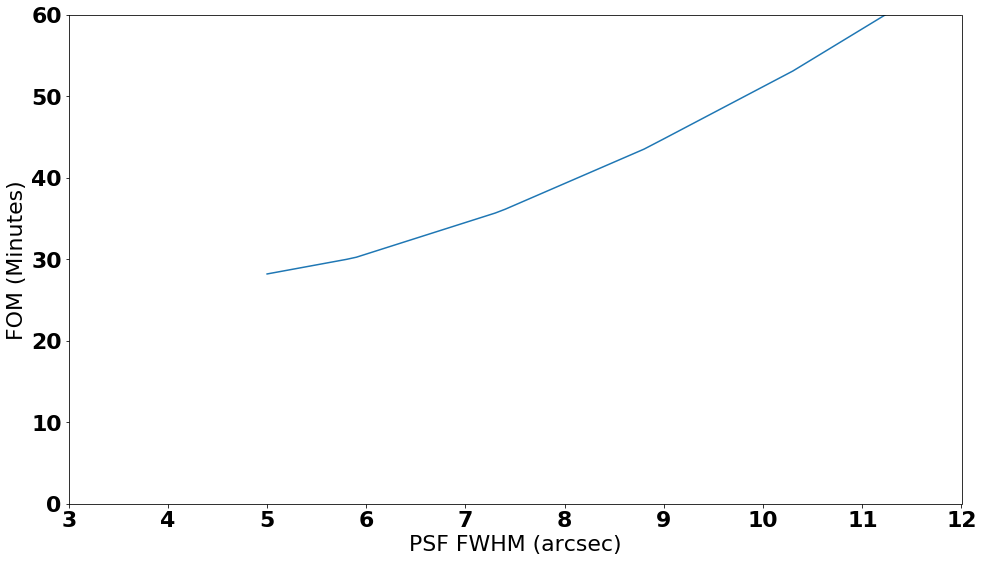

In [53]:
f = plt.figure(figsize=[16, 9])
plt.plot(psfs, foms)
plt.xlabel('PSF FWHM (arcsec)')
plt.ylabel('FOM (Minutes)')
plt.xlim([3, 12])
plt.ylim([0, 60])